# Lab 4 - ML Experiments in Python
- **Author:** Emily Aiken ([emilyaiken@berkeley.edu](mailto:emilyaiken@berkeley.edu)) (based on labs from Dimitris Papadimitriou and Guanghua Chi)
- **Date:** February 16, 2022
- **Course:** INFO 251: Applied machine learning

## Learning objectives:
At the end of this lab, you will be able to...
- Implement random train-test splits and cross validation in numpy and pandas
- Use built-in scikit-learn functionality for train-test splits and cross validation
- Understand the difference between cross validation and the bootstrap
- Understand the difference between normalization and standardization

## Topics:
1. Vectorized computation, revisited
2. Train-test splits
3. Cross validation
4. Bootstrapping
5. Normalization and standardization

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler

## 1. Vectorized Computation, Revisited

Challenge: For each point in a random set of 2D points, find the index of the closest other point in terms of Euclidean distance. *Use a maximum of one for loop.*

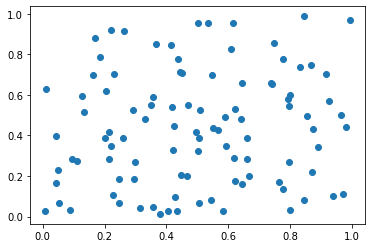

In [2]:
np.random.seed(2)
points = np.random.rand(100, 2)

fig, ax = plt.subplots(1)
ax.scatter(points[:, 0], points[:, 1])
plt.show()

In [3]:
# Solution: Bad example
closest_points = []
for i in range(len(points)):
    x1, y1 = points[i,:]
    dists = []
    for j in range(len(points)):
        if j == i: # do not compare with itself
            dists.append(np.inf)
        if j != i: 
            x2, y2 = points[j,:]
            dists.append(np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2))
    closest_points.append(np.argmin(dists))

In [4]:
# Solution: Good example
closest_points = []
for i in range(len(points)):
    dists = np.sqrt(np.sum((points - points[i, :])**2, axis=1))
    dists[i] = np.inf
    closest_points.append(np.argmin(dists))

## 2. Random Splits

In [5]:
df = pd.read_csv('auto.csv')
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


#### Option 1: Shuffling in numpy
This is what you should be using for your problem sets! 

In [6]:
train_percent = .80
train_number = int(train_percent*len(df))
print('Total examples: %i' % len(df))
print('Number of training examples: %i' % train_number)
print('Number of testing examples: %i' % (len(df) - train_number))

np.random.seed(1)

ids = np.arange(0, len(df), 1)
ids = np.random.permutation(ids)
df_shuffled = df.iloc[ids]
train = df_shuffled[:train_number]
test = df_shuffled[train_number:]

Total examples: 397
Number of training examples: 317
Number of testing examples: 80


#### Option 2: Shuffling in pandas
Arguably more idiomatic, but less flexible. Don't use on PS3 or PS4, but could be useful in future data science applications.

In [7]:
df_shuffled = df.sample(frac=1, random_state=12, replace=False)
train = df_shuffled[:train_number]
test = df_shuffled[train_number:]

#### Option 3: Built-in functionality in scikit-learn
Often most convenient -- but don't use built-in sklearn functionality in PS3 or PS4.

In [8]:
train, test = train_test_split(df, train_size=train_percent, shuffle=True, random_state=12)

In [9]:
x = df[['mpg', 'cylinders', 'year']]
y = df['weight']
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=train_percent, shuffle=True, 
                                                    random_state=12)

## 3. Cross Validation

#### Option 1: Cross validation in numpy
**Challenge**: Extract five random cross validation splits from our dataframe using numpy's shuffle()

In [10]:
# Solution 
ids = np.arange(0, len(df), 1)
np.random.shuffle(ids) # What's weird about this syntax?
df_shuffled = df.iloc[ids]

partitions = [int(x) for x in np.linspace(0, len(df), 6)]
splits = [df_shuffled[partitions[i]:partitions[i+1]] for i in range(len(partitions)-1)]

#### Option 2: Cross validation in pandas
**Challenge**: Extract five random cross validation splits from our dataframe using pandas sample()

In [11]:
# Solution
df_shuffled = df.sample(frac=1, random_state=12)

partitions = [int(x) for x in np.linspace(0, len(df), 5)]

splits = [df_shuffled[:i] for i in partitions]

#### Option 3: Built-in functionality in scikit-learn
Once again, do not use sci-kit learn on PS3 or PS4

In [12]:
# KFold -- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html
kf = KFold(n_splits=5, random_state=12)
for train_idx, test_idx in kf.split(df):
    train, test = df.iloc[train_idx], df.iloc[test_idx]
    print(train.shape, test.shape)

(317, 9) (80, 9)
(317, 9) (80, 9)
(318, 9) (79, 9)
(318, 9) (79, 9)
(318, 9) (79, 9)


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


In [13]:
# Cross validate -- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html
x = df[['mpg', 'cylinders', 'year']]
y = df['weight']
model = LinearRegression()
cross_validate(model, x, y, scoring='r2', cv=5)

{'fit_time': array([0.2043469 , 0.01098609, 0.00430489, 0.00438118, 0.01293206]),
 'score_time': array([0.00409317, 0.00400305, 0.00344515, 0.00409985, 0.00381398]),
 'test_score': array([0.87676209, 0.86726229, 0.873267  , 0.76292741, 0.27034231])}

## 4. Bootstrapping
We can think of train-test splits and cross validation as drawing samples without replacement: Once an observation is assigned to a split, it can't be redrawn into another split. 

*Bootstrapping* is the opposite: We draw samples with replacement. Bootstrapping is mostly used for estimating confidence intervals around point estimates --- more to come on bootstrapping in later lectures and labs!


#### Option 1: Random draws with numpy

In [14]:
np.random.seed(1)

n_bootstraps = 100
sample_size = 50
for i in range(n_bootstraps):
    sample_ids = np.random.choice(len(df), size=sample_size)
    bootstrap_sample = df.iloc[sample_ids]
    print(bootstrap_sample['mpg'].mean())

24.66
23.552000000000003
24.416000000000004
25.456
22.644000000000002
23.184
23.631999999999998
24.596000000000004
24.127999999999997
24.294
23.308000000000003
24.15
23.232000000000003
24.596000000000004
23.78
21.908
23.674
23.076000000000004
23.302
24.592
23.87
22.25
22.965999999999994
21.626000000000005
23.942000000000004
22.913999999999998
23.644000000000005
23.513999999999996
24.387999999999998
22.51
23.802
24.564000000000007
22.695999999999998
25.418000000000003
24.917999999999996
22.202
22.855999999999998
24.036000000000005
23.177999999999997
24.018000000000008
24.061999999999998
21.18
24.51
24.054000000000002
22.68
23.651999999999997
23.031999999999996
23.424
22.633999999999997
22.682
22.241999999999997
22.836
22.914
22.170000000000005
22.432
22.055999999999997
23.471999999999998
22.713999999999995
23.320000000000004
25.581999999999994
24.972
24.908
22.616
24.408
21.124000000000002
26.92
22.444000000000003
22.035999999999998
23.727999999999998
21.491999999999994
23.728
25.805999

#### Option 2: Random draws with pandas

In [15]:
np.random.seed(2)

n_bootstraps = 100
sample_size = 50

for i in range(n_bootstraps):
    bootstrap_sample = df.sample(sample_size, replace=True)
    print(bootstrap_sample['mpg'].mean())

24.261999999999997
23.622
22.732000000000003
23.727999999999998
22.9
22.858
23.662000000000003
23.474000000000004
25.37
23.53
23.938000000000002
23.355999999999998
25.28
24.168000000000003
24.077999999999996
22.613999999999997
22.118000000000002
24.212000000000003
23.040000000000006
23.508000000000003
23.52
24.756000000000004
21.421999999999997
24.528000000000002
24.526
24.95
22.236
22.058000000000003
23.378
25.230000000000004
22.935999999999993
22.334
24.056000000000004
23.45
25.603999999999996
22.619999999999994
24.230000000000004
25.433999999999997
22.086
23.458000000000002
22.380000000000006
24.298000000000002
24.034000000000002
23.86
25.376000000000005
24.787999999999997
23.418000000000003
20.944000000000003
22.522000000000002
23.296
25.179999999999996
25.366000000000003
23.921999999999997
24.37
23.485999999999994
24.524
24.080000000000005
23.741999999999997
24.060000000000006
26.232
24.59
25.396000000000004
24.464000000000006
23.833999999999996
23.718000000000004
23.32
22.1920000

## 5. Normalization and Standardization

In [16]:
df_numeric = df[['mpg', 'cylinders', 'weight']]
train, test = train_test_split(df_numeric, test_size=0.8, random_state=1, shuffle=True)

mpg_train = train['mpg'].values.flatten()
mpg_test = test['mpg'].values.flatten()

#### Standardization
Standardization rescales the values in a vector to 0 mean and unit variance.

In [17]:
# Standardization by hand in numpy
mean_mpg, std_mpg = np.mean(mpg_train), np.std(mpg_train)

mpg_train_standardized = (mpg_train - mean_mpg)/std_mpg
mpg_test_standardized = (mpg_test - mean_mpg)/std_mpg

print(mpg_train_standardized.mean(), mpg_train_standardized.std())
print(mpg_test_standardized.mean(), mpg_test_standardized.std())

4.946816514785507e-16 1.0000000000000002
0.24076296260385305 1.1888702802210738


In [18]:
# Standardization with scikit-learn
scaler = StandardScaler()
train_standardized = scaler.fit_transform(train)
test_standardized = scaler.transform(test)

#### Normalization
Normalization rescales the values in a vector to a range of [0, 1].

In [19]:
# Normalization by hand in numpy
max_mpg, min_mpg = np.max(mpg_train), np.min(mpg_train)

mpg_train_normalized = (mpg_train - min_mpg)/(max_mpg - min_mpg)
mpg_test_normalized = (mpg_test - min_mpg)/(max_mpg - min_mpg)

print(mpg_train_normalized.min(), mpg_train_normalized.max())
print(mpg_test_normalized.min(), mpg_test_normalized.max())

0.0 1.0
-0.04 1.464


In [20]:
# Normalization in scikit-learn
scaler = MinMaxScaler()
train_normalized = scaler.fit_transform(train)
test_normalized = scaler.transform(test)